# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

## VisCPU

In [31]:
from hera_sim.visibilities import VisCPU
import numpy as np
import healpy
import matplotlib.pyplot as plt
%matplotlib inline

``VisCPU`` natively deals with diffuse emission, and the ``VisibilitySimulator`` uses ``healpix`` maps to represent such emission:

In [26]:
NSIDE = 20
NPIX = 12 * NSIDE**2 # this is the number of pixels a healpix map has for  given NSIDE

# Create a pure white noise sky
sky_intensity = np.random.normal(100, 0.01, size=NPIX)

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` _requires_ a frequency, set of antenna positions, a latitude for the array, and a set of LSTs at which to compute the visibilities. Everything else is optional. Let's begin with this minimal set:

In [27]:
lsts = np.linspace(0, 2*np.pi, 100)
latitude = -26/180.0
antpos = \
np.array([
    [0,0,0],
    [0,20,0]
])

In [28]:
simulator = VisCPU(
    freq = 0.15, # GHz
    antpos = antpos,
    latitude = latitude,
    lsts = lsts,
    sky_intensity = sky_intensity
)

In [29]:
vis = simulator.simulate()

[]


Text(0.5, 0, 'LST')

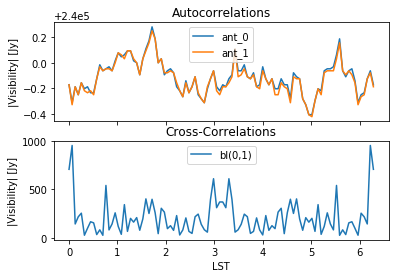

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True, 
                       subplot_kw={"ylabel":"|Visibility| [Jy]"})

for i in range(len(antpos)):
    ax[0].plot(lsts, np.abs(vis[:, i,i]), label=f"ant_{i}")
    
    for j in range(len(antpos))[(i+1):]:
        ax[1].plot(lsts, np.abs(vis[:, i,j]), label=f"bl({i},{j})")

ax[0].legend()
ax[1].legend()
ax[0].set_title("Autocorrelations")
ax[1].set_title("Cross-Correlations")
ax[1].set_xlabel("LST")

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. The beam can be set as a series of healpix maps, one for each antenna. 
An extra list of ``beam_ids`` specifies which of the beams each antenna uses. So, we can create something like a Gaussian beam:

In [38]:
l,m,n = healpy.pix2vec(NSIDE, np.arange(NPIX))
beam = np.exp(-(l**2 + m**2)/(2 * 0.2**2))

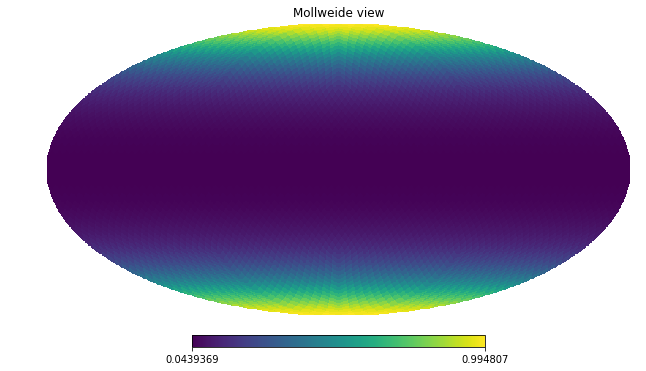

In [37]:
healpy.mollview(beam)

In [39]:
simulator = VisCPU(
    freq = 0.15, # GHz
    antpos = antpos,
    latitude = latitude,
    lsts = lsts,
    sky_intensity = sky_intensity,
    beams = np.array([beam]),
    beam_ids = [0,0]
)

In [40]:
vis = simulator.simulate()

/home/steven/Documents/Projects/radio/EOR/OthersCodes/HERA/hera_sim/hera_sim/visibilities/conversions.py:30: RuntimeWarning: invalid value encountered in sqrt
  n = np.where(lsqr < 1, np.sqrt(1 - lsqr), -1)


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


Text(0.5, 0, 'LST')

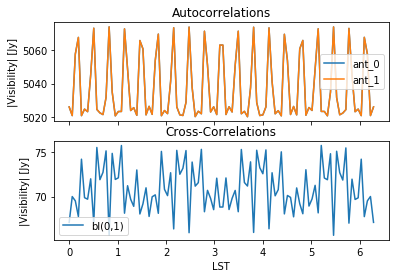

In [41]:
fig, ax = plt.subplots(2, 1, sharex=True, 
                       subplot_kw={"ylabel":"|Visibility| [Jy]"})

for i in range(len(antpos)):
    ax[0].plot(lsts, np.abs(vis[:, i,i]), label=f"ant_{i}")
    
    for j in range(len(antpos))[(i+1):]:
        ax[1].plot(lsts, np.abs(vis[:, i,j]), label=f"bl({i},{j})")

ax[0].legend()
ax[1].legend()
ax[0].set_title("Autocorrelations")
ax[1].set_title("Cross-Correlations")
ax[1].set_xlabel("LST")